## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point.

In [2]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.11.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
# Imports here
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.models as models
import signal
from contextlib import contextmanager
import requests
import json
from torchvision.models import VGG16_Weights
from torch import nn
from torch import optim
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import torchvision.transforms as transforms
import os
import shutil

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


In [5]:
imagenet_data = torchvision.datasets.ImageFolder('/workspace/home/aipnd-project/flowers')
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True)

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [6]:
data_dir = '/workspace/home/aipnd-project/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Define directories
data_dirs = {
    'train': train_dir,
    'valid': valid_dir,
    'test': test_dir
}


# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(data_dirs[x], transform=data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64 if x == 'train' else 32, shuffle=True if x == 'train' else False)
               for x in ['train', 'valid', 'test']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [9]:
DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [10]:
# TODO: Build and train your network
torch.cuda.empty_cache()

# Load a Pre-trained Network

I will be using the VGG16 or alexnet models pre-trained on ImageNet as a feature extractor

In [11]:
def define_model(arch, num_features, num_classes, device):
    # Check if GPU is available and set the device accordingly

    # Initialize the model variable to None
    model = None

    # Load the corresponding pre-trained model based on the architecture
    if arch == 'vgg16':
        model = models.vgg16(pretrained=True)
        num_features = model.classifier[0].in_features
    elif arch == 'alexnet':
        model = models.alexnet(pretrained=True)
        num_features = model.classifier[1].in_features
    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    # Freeze the parameters of the feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the classifier with a custom one for flower species classification
    # Assume num_classes is the number of flower categories
    # Define a Custom Classifier
    # Replacing arch's classifier with my own for flower species classification
    classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )

    model.classifier = classifier
    model = model.to(device)

    return model

In [12]:
num_of_classes = 102
num_features = 4096
arch = 'vgg16'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Check if GPU is available
model = define_model(arch, num_features, num_of_classes, device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 158MB/s]  


# Define the Training Loop

Before defining the training loop, let's set up the loss function and optimizer

Writing the training loop

In [13]:
# Train the model
def train_model(model, criterion, optimizer, dataloaders, num_epochs):
 
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            batch_index = 0
         
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print(f"Processing batch {batch_index + 1} of {phase}")
                batch_index += 1

                # Move inputs and labels to the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)
            
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #torch.cuda.empty_cache()  # Clear unused memory

                # Calculate statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 20

# Train the Network

In [15]:
# Dataloaders is a dictionary containing 'train' and 'valid' DataLoader objects
model_trained = train_model(model, criterion, optimizer, dataloaders, num_epochs)
        
# Save the trained model
# Move the model to CPU and save the checkpoint
#model.to('cpu')
torch.save(model_trained.state_dict(), 'flower_species_classifier.pth')

Epoch 1/20
----------
Processing batch 1 of train
Processing batch 2 of train
Processing batch 3 of train
Processing batch 4 of train
Processing batch 5 of train
Processing batch 6 of train
Processing batch 7 of train
Processing batch 8 of train
Processing batch 9 of train
Processing batch 10 of train
Processing batch 11 of train
Processing batch 12 of train
Processing batch 13 of train
Processing batch 14 of train
Processing batch 15 of train
Processing batch 16 of train
Processing batch 17 of train
Processing batch 18 of train
Processing batch 19 of train
Processing batch 20 of train
Processing batch 21 of train
Processing batch 22 of train
Processing batch 23 of train
Processing batch 24 of train
Processing batch 25 of train
Processing batch 26 of train
Processing batch 27 of train
Processing batch 28 of train
Processing batch 29 of train
Processing batch 30 of train
Processing batch 31 of train
Processing batch 32 of train
Processing batch 33 of train
Processing batch 34 of train
P

In [16]:
torch.save(model_trained.state_dict(), 'flower_species_classifier.pth')

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
def test_model(model, dataloaders, device):
    model.eval()  # Set the model to evaluation mode

    corrects = 0
    total = 0

    with torch.no_grad():  # No need to track gradients
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = 100 * corrects.double() / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Assuming the model, device, and dataloaders are already defined and the model is trained
test_model(model, dataloaders, device)

Test Accuracy: 70.45%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
def save_checkpoint(model, architecture, image_datasets, optimizer, epochs, checkpoint_path):
    """
    Saves a checkpoint of the model state.

    Parameters:
        model (torch.nn.Module): The trained model.
        architecture (str): The architecture of the model.
        image_datasets (Dataset): The dataset used for training, with class_to_idx attribute.
        optimizer (torch.optim.Optimizer): The optimizer used during training.
        epochs (int): The number of epochs the model was trained for.
        checkpoint_path (str): Path to save the checkpoint.
    """
    
    # Attach the class to index mapping to the model
    model.class_to_idx = image_datasets['train'].class_to_idx

    # Create a checkpoint dictionary
    checkpoint = {
        'architecture': architecture,
        'class_to_idx': model.class_to_idx,
        'state_dict': model.state_dict(),
        'classifier': model.classifier,  # Save the classifier separately
        'optimizer_state': optimizer.state_dict(),
        'epochs': epochs
    }

    # Save the checkpoint
    torch.save(checkpoint, checkpoint_path)


# Example usage
checkpoint_path='model_checkpoint.pth'
image_datasets = image_datasets
epochs=10
architecture = 'vgg16'
# Assuming `model` is the trained model instance and `architecture` is a string like 'vgg16'
save_checkpoint(model, architecture, image_datasets, optimizer, epochs, checkpoint_path)

In [19]:
import os
print(os.getcwd())

/workspace/home/aipnd-project


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [20]:
from torchvision.models import vgg16, VGG16_Weights

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))

    if checkpoint['architecture'] == 'vgg16':
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model.classifier = checkpoint['classifier']
    else:
        # Handle other architectures
        pass

    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    model.to('cpu')  # Move the model to the CPU
    model.device = torch.device('cpu')  # Set the device attribute

    return model

# Load your model (replace 'your_checkpoint_path.pth' with your checkpoint file path)
model = load_checkpoint('model_checkpoint.pth')

In [21]:
checkpoint = torch.load('model_checkpoint.pth', map_location=torch.device('cpu'))
print(checkpoint.keys())

dict_keys(['architecture', 'class_to_idx', 'state_dict', 'classifier', 'optimizer_state', 'epochs'])


In [22]:
print(checkpoint)

{'architecture': 'vgg16', 'class_to_idx': {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a NumPy array
    '''
    # Open the image
    pil_image = Image.open(image_path)

    # Convert image to RGB if it's not
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')

    # Define transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations to the image
    tensor_image = preprocess(pil_image)

    # Convert to NumPy array
    np_image = tensor_image.cpu().detach().numpy()

    # PyTorch models expect the color channel to be in the first dimension
    # but numpy arrays have it in the third dimension
    # This line is already correct, as the tensor is expected to be in CxHxW format
    np_image = np_image.transpose((1, 2, 0))

    # Correcting the color channel position for display
    np_image = np_image.transpose((2, 0, 1))
    return np_image

# Example usage
image_path = "/workspace/home/aipnd-project/assets/Flowers.png"
image = process_image(image_path)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<Axes: >

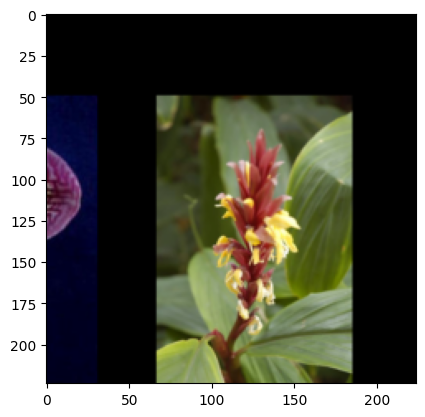

In [24]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Assuming the `image` variable is the NumPy array from the previous `process_image` function
# Convert it back to a tensor for the `imshow` function
image_tensor = torch.from_numpy(image)
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [25]:
# Define the function to predict the class of an image
def predict(image_path, model, topk=5, device='cpu'):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Process the image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        top_probs, top_idxs = probabilities.topk(topk)
    
    # Convert to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_idxs.cpu().numpy()[0]]
    
    return top_probs.cpu().numpy(), top_classes

# Define the model architecture and load the checkpoint
def load_checkpoint(filepath, device='cpu'):
    checkpoint = torch.load(filepath, map_location=device)
    
    model = models.vgg16(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.to(device)
    
    return model

# Assuming 'model_checkpoint.pth' is the path to the checkpoint file and 'path_to_image' is the image file
model = load_checkpoint('model_checkpoint.pth', device='cpu')
image_path = "/workspace/home/aipnd-project/assets/Flowers.png"
probs, classes = predict(image_path, model, topk=5, device='cpu')
print(probs)
print(classes)

[[0.01868493 0.01800413 0.01643405 0.01504264 0.01493905]]
['2', '18', '57', '67', '84']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [26]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

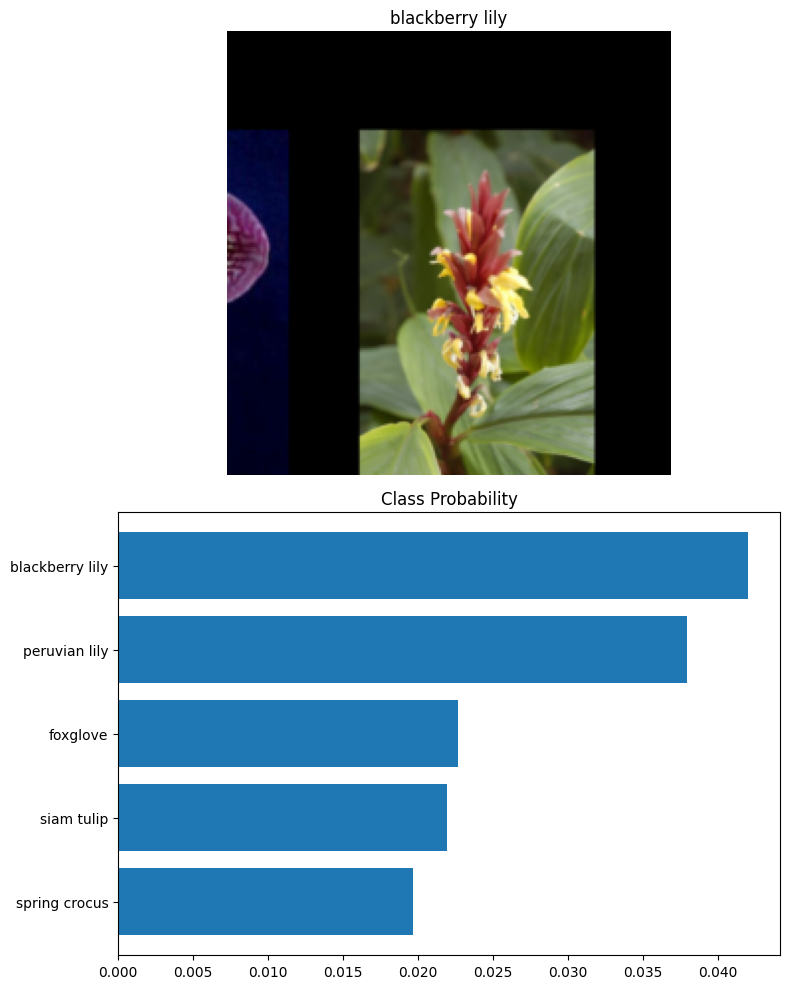

In [27]:
# TODO: Display an image along with the top 5 classes
def process_image(image_path):
    pil_image = Image.open(image_path)
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tensor_image = preprocess(pil_image)
    return tensor_image

def imshow(tensor, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.axis('off')
    if title:
        ax.set_title(title)
    return ax

# The function to display a bar graph for the top classes
def show_prediction_probs(image_path, probs, classes, mapping):
    ''' Function for viewing an image and it's predicted classes with probabilities
    '''
    image = process_image(image_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(8,10), nrows=2)
    flower_names = [mapping[cls] for cls in classes]

    imshow(image, ax=ax1, title=flower_names[0])
    ax1.axis('off')

    y_pos = np.arange(len(probs))
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()
    ax2.set_title('Class Probability')

    plt.tight_layout()
    plt.show()

# Use the function like this:
image_path = '/workspace/home/aipnd-project/assets/Flowers.png'
probs = np.array([0.04202859, 0.0379262, 0.0226989, 0.02193481, 0.01965644])
classes = ['102', '18', '94', '39', '67']

# Show the prediction probabilities with the image
show_prediction_probs(image_path, probs, classes, cat_to_name)

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [28]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace

# Correct source and destination directories
source_dir = "/workspace/home/aipnd-project/"
destination_dir = '/workspace/home/aipnd-project/opt'

# Check if the destination directory exists, create if not
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Move all .pth files to the destination directory
for file_name in os.listdir(source_dir):
    if file_name.endswith('.pth'):
        shutil.move(os.path.join(source_dir, file_name), os.path.join(destination_dir, file_name))

## References

1. https://stackoverflow.com/questions/47474869/getting-a-list-of-all-known-classes-of-vgg-16-in-keras

2. https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

3. https://keras.io/api/applications/vgg/

4. https://www.geeksforgeeks.org/vgg-16-cnn-model/

5. https://pytorch.org/docs/0.3.0/torchvision/index.html

6. https://docs.python.org/2/library/json.html

7. https://pytorch.org/docs/master/torchvision/models.html

8. https://pillow.readthedocs.io/en/latest/reference/Image.html